In [1]:
import numpy as np
import tensorflow as tf
from PIL.ImageEnhance import Contrast
import pydicom
import os
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
import matplotlib.patches as patches
import pickle
import csv

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

c:\users\eric\anaconda2\envs\hse_dl\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('./stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [3]:
with open('yolo_labels_centered_5x5_9c.p', 'rb') as handle:
    labels = pickle.load(handle)

In [4]:
ROOT_DIR = "./"
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')

image_ids = ["72247058-293a-4a90-a972-093fe8f12148", "aef45568-9947-4c75-83d8-3643210d9c3b", 
             "65f038e8-a727-472c-bb76-7a71cd4397f2", "39895c94-84ec-46b6-8a39-f57c99abdbca", 
             "36994bd6-13dc-405e-9f98-680a0e5b2eea", "794c2473-8e8e-4f2b-989a-7148d0737c95"]

image_ids = ["0a66f58c-f98d-41d1-89af-4e0136888e13", "01fa0f5e-00c3-41cb-b5c7-10600c8633ae", "ec910555-f698-4536-aff7-7fa9d3405d60"]

image_ids = ["0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15", "0a66f58c-f98d-41d1-89af-4e0136888e13",
             "f1c3f262-dcfd-4904-b108-38d3479e3201", "0ab261f9-4eb5-42ab-a9a5-e918904d6356", 
             "0afeabf5-d5a3-454f-a50d-887f0d21106c", "1d57c801-71b4-49da-8933-2cabdc927fef", 
             "34fbff70-fa6e-4709-ab07-17f739fce394", "49c04987-96af-4edb-b560-53c56a357cac",
            "b35d57ee-f22b-4c8c-b959-3ee8eecef555", "b6ab1a11-6558-4f76-bed2-3b169f820be9"]

# 5x5 9c
image_ids = ["09db0213-0ad3-4062-bc7b-9a82e5a74097", "0b2057bc-4c6d-4c90-8975-94c02392e460",
    "b6ab1a11-6558-4f76-bed2-3b169f820be9", "b35d57ee-f22b-4c8c-b959-3ee8eecef555",
    "34fbff70-fa6e-4709-ab07-17f739fce394", "371e6626-7884-4232-9629-0220fe6e7172",
    "32827da4-939c-46de-85db-a2d75cb0dfad", "5c65a8b2-7873-4490-9fce-ac4fe0417ada",
             "52523b06-76b3-4a00-aab3-f27815a378c6",
            "656ac314-64a2-4281-8a08-6596c5c5a20e", "703bcb21-559a-4c64-9d9b-6ff164c06218",
            "77762e93-073c-405f-bca5-0f1fd339bf4c","7b3e032d-e3ec-4c61-8a49-785fd6d0d87e",]

# 3x3 9c
# image_ids = ["01fa0f5e-00c3-41cb-b5c7-10600c8633ae", "0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15",
#              "03edb5ed-9e76-4abe-bc35-7bc95fea7e6a", "06f5a38a-e4b1-4e5f-8c62-f48630a52504",
#              "0a66f58c-f98d-41d1-89af-4e0136888e13", "0bed2d9d-8a11-41d9-b312-41f8c93791f7",
#     '315b5137-1117-4090-9329-d6a6fff607ef',
#  '39ced0d0-246c-430d-9bea-efc60bfa487c',
#  '70d7f4df-5497-4205-a36b-e47b58145fa2',
#  '97a6f7c7-df3f-4127-907d-27823c48f2fe',
#  '34d36b9f-af87-4891-b001-6dc4f5379cb2',
#  '6a41e296-8bda-4f84-8766-c253246b77d0',
#  '82edc80d-0b41-45e4-8460-e46f64c67dbf',
#  'b4f66208-8c31-433c-9f82-72104bc35112',
#  '9d5a35ff-4644-4f75-91cf-4ed3142af182',
#  '86ed8bcd-55a0-4b91-8073-0cd11b77c907',
#  '84a14ff5-f4fe-4ee4-9873-ccb84b76d5a8',
#  'ab6f5973-db3c-4c21-8981-189792ea16ee',
#  '777a8a88-5c76-4de9-96fa-7cdd9149e59e',
#  '6bf5ff1a-07df-4c64-8fdf-dd8a26ab9b5b',
#  'a3a15e9c-71d6-440e-9457-89e2aff93fe0',
#  'c208db34-d893-4a2b-9cf2-45490f5b78a3',]

# # 4x4 9c
# image_ids = [
#     "040a0743-f663-4746-8224-f0e3bacc7ba5", "0ab261f9-4eb5-42ab-a9a5-e918904d6356", "308eab64-517b-46f1-8865-d9566b087bff",
#     "31428408-0d97-4ff5-b387-8d1c95cf5a0d", "34d36b9f-af87-4891-b001-6dc4f5379cb2", "040a0743-f663-4746-8224-f0e3bacc7ba5",
#     "0697baae-e475-4fa3-ad82-51b319a026cc", "60670c26-f00c-4139-973e-280d02a2d74d", "7bfcdf16-2730-4b80-bebb-d5889a8fa71e"
# ]

FileNotFoundError: [Errno 2] No such file or directory: './stage_1_train_images\\09db0213-0ad3-4062-bc7b-9a82e5a74097.dcm'

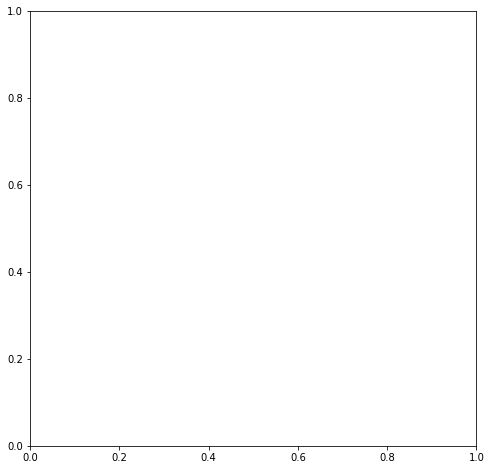

In [5]:
for filename in image_ids:
    fig,ax = plt.subplots(1, figsize=(8,8))
    
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename + ".dcm")).pixel_array
    
    # display the image
    plt.imshow(img)
    
    # display the ROIs from the CSV
    if filename in pneumonia_locations:
        rois = pneumonia_locations[filename]
        
        for roi in rois:
            x,y,w,h = roi
            center_x = x + (w / 2)
            center_y = y + (h / 2)
            
            rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
            plt.plot(center_x, center_y, marker="o", color="b")
            ax.add_patch(rect_1)
            
    # display the labels from the pickle file
    rois = labels[filename]
    for i in range(rois.shape[0]):
        for j in range(rois.shape[1]):
            if rois[i, j, 0] > 0.5:
                x, y, w, h = rois[i, j, 1:]
                # unnormalize the data
                w, h = w*1024, h*1024
                
                CELL_SIZE = 1024 / rois.shape[0]
                GRID_SIZE = rois.shape[0]
                
                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)
                
                # jitter the center a bit
                noise = np.random.uniform(low=-15, high=15)
                
                x = (x - (w / 2)) + noise
                y = (y - (h / 2)) + noise
                
                rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
    plt.title(filename)
    
    # draw the lines
    coords = np.arange(0, 1024, 1024 / GRID_SIZE)
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
        
    plt.show()

In [90]:
labels["5c65a8b2-7873-4490-9fce-ac4fe0417ada"]

array([[[0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ]],

       [[0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ]],

       [[0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [1.        , 0.96078431, 0.99754902, 0.15625   , 0.33496094],
        [0.99   